# Определение токсичности комментариев с BERT

Интернет-магазину нужен инструмент, который будет искать токсичные комментарии пользователей о товарах и отправлять их на модерацию. В нашем распоряжении набор данных с разметкой о токсичности правок.

**Цель исследования** - обучить модель классификации комментариев со значением метрики качества *F1* не меньше 0.75.

**Ход работы**
1. Загрузка и подготовка данных (предобработка, токенизация).
2. Обучение моделей. 
3. Тестирование моделей.
4. Общий вывод.

**Описание данных**
* text - текст комментария;
* toxic — целевой признак, токсичность.

## Подготовка

### Загрузка и обзор данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.utils import shuffle
from torch.nn.utils.rnn import pad_sequence
import transformers 
from tqdm import notebook
from tqdm import tqdm
import torch
import time
import re

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.4f}'.format)
pd.options.mode.chained_assignment = None
rand_state=3208

In [2]:
try:
    toxic_comments = pd.read_csv('/datasets/toxic_comments.csv', index_col='Unnamed: 0')
except:
    toxic_comments = pd.read_csv('datasets/toxic_comments.csv', index_col='Unnamed: 0')

In [3]:
display(toxic_comments.head(10))
display(toxic_comments.describe(include='all'))
toxic_comments.info()

print('\nДубликатов:', toxic_comments.duplicated().sum())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
5,"""\n\nCongratulations from me as well, use the ...",0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word 'nonsense' was offensive to ...,0
9,alignment on this subject and which are contra...,0


,text,toxic
count,159292,159292.0000
unique,159292,NaN
top,Because I want to say this qoute:\n\nSTOP CALL...,NaN
freq,1,NaN
mean,NaN,0.1016
std,NaN,0.3021
min,NaN,0.0000
25%,NaN,0.0000
50%,NaN,0.0000
75%,NaN,0.0000


<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB

Дубликатов: 0


**Выводы**
* Столбец text содержит 159292 уникальных строк с текстами, их необходимо очистить от элементов, не имеющих лингвистического смысла, например "\n";
* Столбец toxic имеет тип integer и значения 0 или 1. Судя по среднему (0.1), наблюдается явный дисбаланс классов. От него нужно будет избавиться перед обучением моделей.

### Предобработка данных

Очистим текстовые данные.

In [4]:
def clear_text(text):
    clean = re.sub(r'[^a-zA-Z ]', ' ', text).split()
    clean = ' '.join(clean)
    return clean

In [5]:
tqdm.pandas()
toxic_comments['text'] = toxic_comments['text'].progress_apply(clear_text)
toxic_comments.head(10)

100%|██████████| 159292/159292 [00:02<00:00, 64191.64it/s]


,text,toxic
0,Explanation Why the edits made under my userna...,0
1,D aww He matches this background colour I m se...,0
2,Hey man I m really not trying to edit war It s...,0
3,More I can t make any real suggestions on impr...,0
4,You sir are my hero Any chance you remember wh...,0
5,Congratulations from me as well use the tools ...,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,Your vandalism to the Matt Shirvington article...,0
8,Sorry if the word nonsense was offensive to yo...,0
9,alignment on this subject and which are contra...,0


Перед тем, как проводить токенизацию, разберемся с дисбалансом классов, чтобы токенизация заняла меньше ресурсов. Изучим соотношение классов.

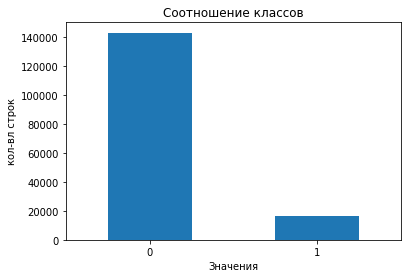

0    143106
1     16186
Name: toxic, dtype: int64


In [6]:
toxic_comments['toxic'].value_counts().plot(kind='bar')
plt.title('Соотношение классов')
plt.xlabel('Значения')
plt.ylabel('кол-вл строк')
plt.xticks(rotation=0)
plt.show()
print(toxic_comments['toxic'].value_counts())

Наблюдается явный дисбаланс классов. Этот дисбаланс должен быть сохранен в тестовой выборке. Поэтому далее:
1. Выделим из датасета часть, чтобы процесс токенизации занял меньше времени. Рассчитаем долю так, чтобы финальный размер обучающей и тестовой выборки был примерно 5000 строк.
2. Разделим получившуюся часть на тестовую и обучающую выборки. 
3. Для обучающей выборки создадим функцию downsample, уменьшим количество нулевых значений так, чтобы оно было соотносимо с единицами.
4. Проведем токенизацию в тестовой и обучающей выборках по отдельности.

Рассчитаем, какую долю датасета взять, в каком соотношении выделять тестовую выборку с учетом того, что обучающая выборка будет изменена.

In [7]:
partition = 5000

ones_per_zeros = toxic_comments['toxic'].value_counts()[1]/len(toxic_comments)
test = partition*0.25
train = (partition*0.75/2) + (partition*0.75/2/ones_per_zeros)
frac = (test+train)/len(toxic_comments)
test_split = test/(train+test)

print('Отношение единичных значений целевого признака к нулевым:', round(ones_per_zeros, 3))
print('Размер тестовой выборки:', int(test))
print('Размеробучающекй выборки до downsample:', int(train)) 
print('Размер выделяемого датасета:', int(test+train))
print('Доля выделяемого датасета:', round(frac, 3))
print('Доля тестовой выборки:', round(test_split, 3))

Отношение единичных значений целевого признака к нулевым: 0.102
Размер тестовой выборки: 1250
Размеробучающекй выборки до downsample: 20327
Размер выделяемого датасета: 21577
Доля выделяемого датасета: 0.135
Доля тестовой выборки: 0.058


In [8]:
features = toxic_comments['text']
target = toxic_comments['toxic']

features_dump, features_sliced, target_dump, target_sliced = train_test_split(
    features, target, test_size=frac, random_state=rand_state)

print('Новая выборка, признаки:', features_sliced.shape)
print('Новая выборка, целевой признак:', target_sliced.shape)

Новая выборка, признаки: (21578,)
Новая выборка, целевой признак: (21578,)


Теперь разделим получившийся датасет на выборку для обучения и тестовую выборку.

In [9]:
features_train, features_test, target_train, target_test = train_test_split(
    features_sliced, target_sliced, test_size=test_split, random_state=rand_state)

print('Обучающая выборка, признаки', features_train.shape)
print('Обучающая выборка, целевой признак', target_train.shape)
print('Тестовая выборка, признаки', features_test.shape)
print('Тестовая выборка, целевой признак', target_test.shape)

Обучающая выборка, признаки (20327,)
Обучающая выборка, целевой признак (20327,)
Тестовая выборка, признаки (1251,)
Тестовая выборка, целевой признак (1251,)


Создалим функцию downsample для обучающей выборки.

In [10]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_zeros = features_zeros.sample(frac=fraction, random_state=rand_state)
    target_zeros = target_zeros.sample(frac=fraction, random_state=rand_state)

    features_downsampled = pd.concat([features_zeros] + [features_ones])
    target_downsampled = pd.concat([target_zeros] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, 
            target_downsampled, random_state=rand_state)
    
    return features_downsampled, target_downsampled

Применим функцию downsample к обучающей выборке и проверим её соотношение с тестовой выборкой

In [11]:
features_downsampled, target_downsampled = downsample(features_train, target_train, ones_per_zeros)

print('Новая выборка, признаки:', features_downsampled.shape)
print('Новая выборка, целевой признак:', target_downsampled.shape)
print('Тестовая выборка, признаки', features_test.shape)
print('Тестовая выборка, целевой признак', target_test.shape)
print()
print('Доля тестовой выборки', round(len(features_test)/(len(features_downsampled)+len(features_test)), 2))

Новая выборка, признаки: (3931,)
Новая выборка, целевой признак: (3931,)
Тестовая выборка, признаки (1251,)
Тестовая выборка, целевой признак (1251,)

Доля тестовой выборки 0.24


Проверим теперь соотношение классов.

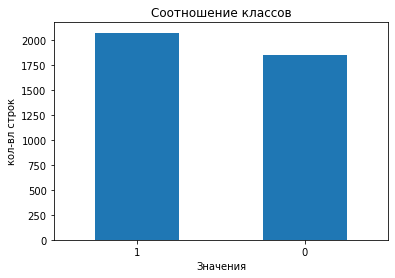

1    2077
0    1854
Name: toxic, dtype: int64


In [12]:
target_downsampled.value_counts().plot(kind='bar')
plt.title('Соотношение классов')
plt.xlabel('Значения')
plt.ylabel('кол-вл строк')
plt.xticks(rotation=0)
plt.show()
print(target_downsampled.value_counts())

Дисбаланс классов преодолен. Теперь проведем токенизацию с помощью BertTokenizer.

In [13]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert')
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')

def get_embeddings(data):
    tokenized = data.progress_apply(lambda x: tokenizer.encode(x, add_special_tokens=True,
                                                                      max_length=512, truncation=True))
    
    padded = pad_sequence([torch.as_tensor(i) for i in tokenized], batch_first=True)
    attention_mask = padded > 0
    attention_mask = attention_mask.type(torch.LongTensor)

    batch_size = 100 
    embeddings = []

    for i in notebook.tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)])
        attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

    data_emb = np.concatenate(embeddings)
    data_emb = pd.DataFrame(data_emb)
    return data_emb

Some weights of the model checkpoint at unitary/toxic-bert were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
features_train_emb = get_embeddings(features_downsampled)
features_test_emb = get_embeddings(features_test)

100%|██████████| 3931/3931 [00:05<00:00, 694.96it/s]


  0%|          | 0/39 [00:00<?, ?it/s]

100%|██████████| 1251/1251 [00:02<00:00, 495.44it/s]


  0%|          | 0/12 [00:00<?, ?it/s]

## Обучение

Теперь обучим несколько моделей. Гиперпараметры подберем при помощи GridSearchCV. Также создадим кросс-валидатор для моделей (KFold). Перед этим обрежем выборки с целевыми признаками так, чтобы они соответствовали выборкам с остальными признаками (после токенизации).

In [15]:
target_downsampled = target_downsampled.reset_index(drop=True)
target_test = target_test.reset_index(drop=True)

target_train_emb = target_downsampled.loc[features_train_emb.index]
target_test_emb = target_test.loc[features_test_emb.index]

print(features_train_emb.shape)
print(target_train_emb.shape)
print(features_test_emb.shape)
print(target_test_emb.shape)

(3900, 768)
(3900,)
(1200, 768)
(1200,)


### LogisticRegression

In [16]:
%%time
kfoldcv = KFold(n_splits=5)

logistic_model = LogisticRegression(random_state=rand_state, class_weight='balanced', solver='liblinear', verbose=0)

parameters = {'tol': [t for t in np.linspace(0.0001, 2, 20)],
              'C': [c for c in np.linspace(0.01, 2, 20)]}

gridsearch_logistic_model = GridSearchCV(logistic_model, parameters, cv=kfoldcv, scoring='f1', verbose=0)
gridsearch_logistic_model.fit(features_train_emb, target_train_emb)

logistic_model = gridsearch_logistic_model.best_estimator_
logistic_f1 = gridsearch_logistic_model.best_score_

print('Модель типа LogisticRegression')
print('f1_score:', logistic_f1)
gridsearch_logistic_model.best_params_

Модель типа LogisticRegression
f1_score: 0.9777332877092235
CPU times: total: 3min 6s
Wall time: 3min 8s


{'C': 0.11473684210526315, 'tol': 0.0001}

### RandomForestClassifier

In [17]:
%%time

forest_model = RandomForestClassifier(random_state=rand_state)

parameters = {'n_estimators': range(40, 81, 10),
              'max_depth': range(2, 11)}

gridsearch_forest_model = GridSearchCV(forest_model, parameters, cv=kfoldcv, scoring='f1', verbose=0)
gridsearch_forest_model.fit(features_train_emb, target_train_emb)

forest_model = gridsearch_forest_model.best_estimator_
forest_f1 = gridsearch_forest_model.best_score_

print('Модель типа RandomForestClassifier')
print('f1_score:', forest_f1)
gridsearch_forest_model.best_params_

Модель типа RandomForestClassifier
f1_score: 0.9768459371807523
CPU times: total: 5min 56s
Wall time: 6min


{'max_depth': 4, 'n_estimators': 40}

### CatBoostClassifier

In [18]:
%%time

cbc_model = CatBoostClassifier(random_seed=rand_state, silent=True)

parameters = {'learning_rate': [0.05],                    #[0.05, 0.1]
              'iterations': [20],                         #[20, 40, 60]
              'depth': [7]}                               #range(3, 11)

gridsearch_cbc_model = GridSearchCV(cbc_model, parameters, cv=kfoldcv, scoring='f1', verbose=0)
gridsearch_cbc_model.fit(features_train_emb, target_train_emb)

cbc_model = gridsearch_cbc_model.best_estimator_
cbc_f1 = gridsearch_cbc_model.best_score_

print('Модель типа CatBoostClassifier')
print('f1_score:', cbc_f1)
gridsearch_cbc_model.best_params_

Модель типа CatBoostClassifier
f1_score: 0.9782647734179652
CPU times: total: 1min 38s
Wall time: 28.6 s


{'depth': 7, 'iterations': 20, 'learning_rate': 0.05}

### LGBMClassifier

In [19]:
%%time

lgbm_model = LGBMClassifier(boosting_type='gbdt', random_state=rand_state)

parameters = {'learning_rate': [0.05],           #[0.05, 0.1, 0.15]
              'n_estimators': [60],              #range(60, 111, 10)
              'num_leaves': [31]}                #range(31, 92, 10)

gridsearch_lgbm_model = GridSearchCV(lgbm_model, parameters, cv=kfoldcv, scoring='f1')
gridsearch_lgbm_model.fit(features_train_emb, target_train_emb)

lgbm_model = gridsearch_lgbm_model.best_estimator_
lgbm_f1 = gridsearch_lgbm_model.best_score_

print('Модель типа LGBMClassifier')
print('f1_score:', lgbm_f1)
gridsearch_lgbm_model.best_params_

Модель типа LGBMClassifier
f1_score: 0.9782932464090516
CPU times: total: 36.6 s
Wall time: 9.66 s


{'learning_rate': 0.05, 'n_estimators': 60, 'num_leaves': 31}

In [20]:
models = pd.Series(['LogisticRegression', 'RandomForestClassifier', 'CatBoostClassifier', 'LGBMClassifier'])
f1_scores = pd.DataFrame([logistic_f1, forest_f1, cbc_f1, lgbm_f1], index=models, columns=['F1'])
f1_scores

,F1
LogisticRegression,0.9777
RandomForestClassifier,0.9768
CatBoostClassifier,0.9783
LGBMClassifier,0.9783


**Выводы**

Наилучшие результаты показали модели CatBoostClassifier с гиперпараметрами depth=7, iterations=20, learning_rate=0.05 и LGBMClassifier с гиперпараметрами learning_rate=0.05, n_estimators=60, num_leaves=31. F1 в обоих случаях 0.978. LGBMClassifier при этом существенно быстрее обучается.

## Тестирование

Протестируем полученные модели. Измерим качество моделей на тестовой выборке.

In [21]:
dummy = DummyClassifier(strategy='constant', random_state=rand_state, constant=1)
dummy.fit(features_train_emb, target_train_emb)

metrics = []

for model in [logistic_model, forest_model, cbc_model, lgbm_model, dummy]:
    string = []
    predictions = model.predict(features_test_emb)
    string.append(f1_score(target_test_emb, predictions))
    string.append(accuracy_score(target_test_emb, predictions))
    string.append(precision_score(target_test_emb, predictions))
    string.append(recall_score(target_test_emb, predictions))
    metrics.append(string)

models[4] = 'Dummy - constant'
metrics = pd.DataFrame(metrics, index=models, columns=['F1', 'Accuracy', 'Precision', 'Recall'])
metrics

,F1,Accuracy,Precision,Recall
LogisticRegression,0.8516,0.9683,0.7569,0.9732
RandomForestClassifier,0.8365,0.9642,0.7285,0.9821
CatBoostClassifier,0.8397,0.9650,0.7333,0.9821
LGBMClassifier,0.8594,0.9700,0.7639,0.9821
Dummy - constant,0.1707,0.0933,0.0933,1.0000


Все модели показывают хорошее качество на тестовой выборке, больше 0.75. Но наилучшие результаты демонстирует модель типа LGBMClassifier (F1 = 0.859).

## Общий вывод

Для интернет-магазина необходимо было обучить модель классификации комментариев на позитивные и негативные, со значением метрики качества *F1* не меньше 0.75. В нашем распоряжении набор данных с разметкой о токсичности.

На первом этапе данные были загружены и проанализированы. Столбец text изначально содержал 159292 уникальных строк с текстами, они были очищены от элементов, не имеющих лингвистического смысла, например "\n".

Столбец toxic имеет тип integer и значения 0 или 1. Был выявлен дисбаланс классов. С помощью функции downsample() уменьшили количество нулевых значений так, чтобы оно было соотносимо с единицами. Также, чтобы процесс выполнился быстрее, ещё сократили выборку до 5000 строк.

Далее была произведена токенизация и созданы эмбеддинги с помощью DistilBertTokenizer и DistilBertModel. Датасет был разделен на выборку для обучения и тестовую выборку. Также был создан кросс-валидатор для моделей (KFold).

Далее были обучены модели LogisticRegression, RandomForestClassifier, CatBoostClassifier, LGBMClassifier, гиперпараметры подобраны при помощи GridSearchCV. Наилучшие результаты показали модели CatBoostClassifier с гиперпараметрами depth=7, iterations=20, learning_rate=0.05 и LGBMClassifier с гиперпараметрами learning_rate=0.05, n_estimators=60, num_leaves=31. F1 в обоих случаях 0.978. LGBMClassifier при этом существенно быстрее обучается.

Далее метрика F1 полученных моделей была измерена на тестовой выборке. Все модели показали хорошее качество на тестовой выборке, больше 0.75. Но наилучшие результаты продемонстировала модель типа LGBMClassifier (F1: 0.859, Accuracy: 0.97, Precision: 0.764, Recall: 0.982).